# IMPORTS AND GENERAL FUNCTIONS

In [314]:
# default_exp preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import glob
import os
import chart_studio.plotly as py
import plotly.graph_objects as go
import missingno as msno
import itertools 
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble  import RandomForestRegressor

from modules import preprocessing as prep
from modules import data_management as dm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
path_base = "./local/data/"

# METEREOLOGICAL DATA

# Workflow con datos del mapa del IDEAM

Poner en una única carpeta todos los archivos descargados para una ubicación dada.

Estoy trabajando en lograr que las descargas de la API queden con los mismos campos que las del IDEAM.

Las variables son: 

- "HRA2_AUT_60" <- HUMEDAD RELATIVA A 2 METROS, HORARIA
- "TA2_AUT_60" <- TEMPERATURA A 2 METROS, HORARIA
- "PTPM_CON" <- PRECIPITACIÓN, DIARIA
- "VV_AUT_2" <- VELOCIDAD DLE VIENTO CADA DOS MINUTOS

En todos los casos habrá que combinar datos de varias estaciones, los criterios preferibles son:

1. Correlación (implementación pendiente)
2. Proximidad en altitud (dato solo disponible para las estaciones del mapa del IDEAM)
3. Proximidad en longitud y latitud.

In [316]:
df_cities = dm.read_cities_file()
df_cities

department   municipality   code                  dl_folder  \
0            Antioquia       Medellín  05001              MEDELLIN_DATA   
1            Magdalena    Santa Marta  47001           SANTA_MARTA_DATA   
2            Santander    Bucaramanga  68001           BUCARAMANGA_DATA   
3            Atlántico   Barranquilla  08001  SOLEDAD_BARRANQUILLA_DATA   
4            Atlántico        Soledad  08758  SOLEDAD_BARRANQUILLA_DATA   
5   Norte de Santander         Cúcuta  54001                CUCUTA_DATA   
6      Valle del Cauca           Cali  76001                  CALI_DATA   
7      Valle del Cauca        Palmira  76563                  CALI_DATA   
8              Caquetá  Villavicencio  50001         VILLAVICENCIO_DATA   
9               Tolima         Ibagué  73001                IBAGUE_DATA   
10             Córdoba       Montería  23001              MONTERIA_DATA   
11           Antioquia          Bello  05088              MEDELLIN_DATA   
12            Amazonas        Leticia  91001               LETICIA_DATA   
13            Amazonas  Puerto Nariño  91540            PUERTO_NAR_DATA   

   starting_date                   stations_temp  \
0     2011/05/20  [27015330, 27015310, 27015300]   
1     2008/06/28                      [15015120]   
2     2014/12/11                      [23195230]   
3     2013/05/03            [29045190, 29004520]   
4     2007/01/01                              []   
5     2006-09-03            [16015110, 16015501]   
6     2006/11/24            [26085170, 26055120]   
7     2006/11/24                              []   
8     2007/03/18            [35035100, 35025110]   
9     2007/01/01                              []   
10    2007/01/01                              []   
11    2007/01/01                              []   
12    2014/07/31            [48015010, 48015050]   
13    2007/01/01                              []   

                      stations_hum                             stations_prec  \
0   [27015330, 27015310, 27015300]            [27015330, 27015290, 27011270]   
1                       [15015120]            [15015050, 15010501, 15015120]   
2                       [23195230]                                [23195230]   
3                       [29045190]            [29045120, 29040450, 29045190]   
4                               []                                        []   
5             [16015110, 16015501]            [16015110, 16015010, 16015501]   
6             [26085170, 26055120]            [26055120, 26080310, 26085170]   
7                               []                                        []   
8             [35035100, 35025110]  [35030380, 35030370, 35030100, 35035020]   
9                               []                                        []   
10                              []                                        []   
11                              []                                        []   
12            [48015010, 48015050]                      [48015050, 48015010]   
13                              []                                [48015040]   

   stations_rad    range_temp    range_hum  
0            []  [15.5, 37.5]  [15, 99.99]  
1            []    [17.5, 40]  [40, 99.99]  
2            []      [17, 40]  [30, 99.99]  
3            []      [22, 45]  [45, 99.99]  
4            []            []           []  
5            []    [17.5, 45]  [30, 99.99]  
6            []    [16.5, 45]  [30, 99.99]  
7            []            []           []  
8            []      [20, 45]  [35, 99.99]  
9            []            []           []  
10           []      [22, 45]  [45, 99.99]  
11           []      [22, 45]  [45, 99.99]  
12           []      [22, 45]    [55, 120]  
13           []      [22, 45]     [5, 120]

In [317]:
row_id = 8
params = {}
params_to_get = ["department","municipality","dl_folder","code", "starting_date","stations_temp","stations_hum","stations_prec","stations_rad","range_temp","range_hum"]
params = {param:df_cities.loc[row_id,param] for param in params_to_get}
params

{'department': 'Caquetá',
 'municipality': 'Villavicencio',
 'dl_folder': 'VILLAVICENCIO_DATA',
 'code': '50001',
 'starting_date': '2007/03/18',
 'stations_temp': [35035100, 35025110],
 'stations_hum': [35035100, 35025110],
 'stations_prec': [35030380, 35030370, 35030100, 35035020],
 'stations_rad': [],
 'range_temp': [20, 45],
 'range_hum': [35, 99.99]}

In [318]:
municipality_name = params["municipality"]
cod_municipio = params["code"]
foldername = path_base+"src_per_city/"+params["dl_folder"]
filenames = sorted(glob.glob(foldername+'/*.csv'))
df = prep.read_csv_IDEAM(filenames).drop_duplicates()
df.drop_duplicates(subset=["CodigoEstacion"])

CodigoEstacion                                     NombreEstacion  \
0             44045020                              VALPARAISO [44045020]   
803           35035100                ICA VILLAVICENCIO  - AUT [35035100]   
21790         35025110                       LA LIBERTAD - AUT [35025110]   
161984        35030040                  ACUEDUCTO LA ESMERALDA [35030040]   
163575        35035020                   AEROPUERTO VANGUARDIA [35035020]   
165400        35030100                                ALCALDIA [35030100]   
167166        35035010                        BASE AEREA APIAY [35035010]   
168922        35030370  ICA VILLAVICENCIO [35030370]VILLAVICENCIO SEDE...   
169206        35030380                             IDEAM V/CIO [35030380]   
171059        35030290                                 SERVITA [35030290]   
172883        35035070                               UNILLANOS [35035070]   
185701        35030050                             OJO DE AGUA [35030050]   
209490        35020060                                 POMPEYA [35020060]   
661627      3502700090                                    GUAYURIBA - AUT   
663290        35027140                            PUENTE CARRETERA  - AUT   
663360        35037100                                PUENTE ABADIA - AUT   

             Latitud   Longitud  Altitud             Categoria  \
0           1.195250 -75.704472    270.0   Climática Ordinaria   
803             4.14 -73.620000    444.0     Agrometeorológica   
21790   4.0573611110 -73.467917    336.0     Agrometeorológica   
161984  4.1636388890 -73.647722    550.0         Pluviográfica   
163575  4.1619194440 -73.617578    422.0   Sinóptica Principal   
165400          4.15 -73.633333    470.0         Pluviográfica   
167166  4.0771111110 -73.559917    400.0  Sinóptica Secundaria   
168922          4.14 -73.620000    444.0         Pluviométrica   
169206  4.1440833330 -73.641833    503.0         Pluviométrica   
171059  4.1888055560 -73.693111    191.0         Pluviográfica   
172883  4.0767222220 -73.582000    340.0   Climática Principal   
185701  4.0911388890 -73.448778    300.0         Pluviométrica   
209490      4.039750 -73.368000    260.0         Pluviométrica   
661627   3.958169444 -73.295536      NaN                    mm   
663290   4.070194444 -73.762500      NaN                    mm   
663360   4.235333333 -73.635361      NaN                    mm   

                                                  Entidad  \
0       INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
803     INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
21790   INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
161984  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
163575  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
165400  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
167166  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
168922  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
169206  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
171059  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
172883  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
185701  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
209490  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
661627                                                NaN   
663290                                                NaN   
663360                                                NaN   

                                    AreaOperativa Departamento      Municipio  \
0               Area Operativa 04 - Huila-Caquetá      Caqueta     Valparaíso   
803     Area Operativa 03 - Meta-Guaviare-Guainía         Meta  Villavicencio   
21790   Area Operativa 03 - Meta-Guaviare-Guainía         Meta  Villavicencio   
161984  Area Operativa 03 - Meta-Guaviare-Guainía         Meta  Villavicencio   
163575  Area Operativa 03 - Meta-Guaviare-Guainía         Meta  Villavicencio   
165400  Area Operativa 03 - Meta-Guaviare-Guainía  

# Workflow precipitación

1. Lectura y visualización inicial:

In [319]:
standard_var_name = "PRECIPITATION"
possible_prec_names = ["PTPM_CON","Precipitacion"]
df_prec = prep.get_variable_IDEAM(df, possible_prec_names, standard_var_name)
df_prec = prep.drop_duplicates_by_date_station(df_prec)
stations_prec = df.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_prec = df_prec[df_prec["CodigoEstacion"].isin(stations_prec)]

In [320]:
fig = go.Figure()
for df_group in df_prec.groupby(["CodigoEstacion"]):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_lluvia = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name], name ="PP "+str(codigoestacion), mode = "lines")
    fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY " +standard_var_name + " IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [321]:
df_prec_daily = df_prec 
df_prec_daily.head()

CodigoEstacion  PRECIPITATION
DATE                                     
2020-01-01        44045020            0.4
2020-01-02        44045020            0.0
2020-01-03        44045020            0.0
2020-01-04        44045020            0.0
2020-01-05        44045020            0.0

### Escoger hasta 6 estaciones para el análisis de correlación, en caso de que hayan muchas estaciones, sino basta con utilizar el unique

In [322]:
stations_corr =  df_prec_daily["CodigoEstacion"].unique()
#stations_corr = [29004520, 29040450, 29045190]
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_prec_daily[df_prec_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['PRECIPITATION'],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['PRECIPITACION'] = corr_table.corr().iloc[0,1]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

44045020                                                \
              35030040   35035020   35030100   35035010   35035100     
PRECIPITACION   0.283686   0.190775   0.480694        NaN   0.282703   

                                                                      ...  \
              35030370   35030380   35025110   35030290   35035070    ...   
PRECIPITACION   0.189252   0.201394   0.207825   0.127833    0.16171  ...   

              35030050                                    35020060    \
              35020060   3502700090 35027140   35037100   3502700090   
PRECIPITACION   0.156117  -0.020044   0.187161   0.038271        NaN   

                                    3502700090            35027140    
              35027140   35037100   35027140   35037100   35037100    
PRECIPITACION        NaN   0.184613    0.18161   0.183428        NaN  

[1 rows x 120 columns]

##  2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.

In [323]:
if len(params["stations_prec"]) == 0:
    stations_priority = [48015050, 48015010] 
    params["stations_prec"] = stations_priority
    df_cities.loc[row_id,"stations_prec"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_prec"]
    print("Estaciones utilizadas para precipitación:", params["stations_prec"])

df_prec_daily = prep.combine_IDEAM_stations(df_prec_daily, stations_priority).sort_index()
df_prec_daily = df_prec_daily.resample('D').mean()

Estaciones utilizadas para precipitación: [35030380, 35030370, 35030100, 35035020]


In [324]:
fig = go.Figure()

plot_lluvia = go.Scatter(x=df_prec_daily.index, y=df_prec_daily[standard_var_name], name ="PP ", mode = "lines")
fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))

fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

3. Variables compuestas o derivadas de los valores diarios

# Workflow temperatura

In [325]:
standard_var_name = "TEMPERATURE"
possible_temp_names = ["TA2_AUT_60", "Temp Aire 2 m"]
df_temp = prep.get_variable_IDEAM(df, possible_temp_names, standard_var_name).sort_index()
df_temp = prep.drop_duplicates_by_date_station(df_temp)
stations_temp = df_temp.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_temp = df_temp[df_temp["CodigoEstacion"].isin(stations_temp)]
stations_temp

array([35035100, 35025110], dtype=int64)

1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

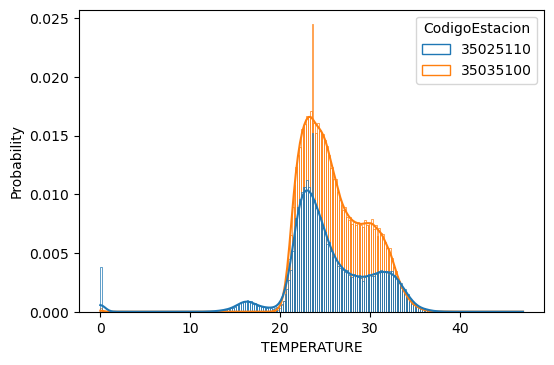

In [326]:
dfs = []
unique_stations = df_temp["CodigoEstacion"].unique()
fig = plt.figure(dpi=100)
sns.histplot(data = df_temp, x = "TEMPERATURE", hue = "CodigoEstacion",  palette = sns.color_palette("tab10")[0:len(unique_stations)], kde = True, fill = False, common_norm = True, stat = 'probability')
for i, codigoestacion in enumerate(unique_stations):
    df_temp_est =back = df_temp[df_temp["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    #print(codigoestacion,df_temp_est.describe())
    df_temp_est = prep.filter_entries_by_column_index_values(df_temp_est, standard_var_name, params["range_temp"][0],params["range_temp"][1]); # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_temp_est = prep.aggregate_data(df_temp_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_temp_est.columns)
    df_temp_est["CodigoEstacion"] = codigoestacion
    df_temp_est = df_temp_est[columns]
    dfs.append(df_temp_est)
df_temp_daily = pd.concat(dfs, axis = 0)

In [327]:
fig = go.Figure()
for df_group in df_temp_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="TEMP "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='TEMP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [328]:
if params["municipality"] == "Medellín":
    indexes_fix = df_temp_daily["TEMPERATURE_MEAN"]>26.5
    df_temp_daily.loc[indexes_fix,["TEMPERATURE_MEAN","TEMPERATURE_AMAX","TEMPERATURE_AMIN"]] = None

In [329]:
stations_corr =  df_temp_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_temp_daily[df_temp_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['TEMPERATURE_AMAX','TEMPERATURE_AMIN',"TEMPERATURE_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['TEMPERATURE_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['TEMPERATURE_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['TEMPERATURE_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

35035100
                  35025110
TEMPERATURE_AMAX  0.867033
TEMPERATURE_AMIN  0.773220
TEMPERATURE_MEAN  0.920368

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [330]:
# Manually set the priorities for the temperature stations as per the above results!
#params["stations_temp"] = []
if len(params["stations_temp"]) == 0:
    stations_priority = [48015010,48015050]
    params["stations_temp"] = stations_priority
    df_cities.loc[row_id,"stations_temp"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_temp"]

#stations_priority = [26085170,26055120] #Cali
#stations_priority = [29045190, 29004520   ] #Barranquilla
df_temp_daily = prep.combine_IDEAM_stations(df_temp_daily, stations_priority).sort_index()
df_temp_daily = df_temp_daily.resample('D').mean()

#df_temp_daily = df_temp_daily[df_temp_daily.index.date >= pd.to_datetime("2013/05/01")]

In [331]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_temp_daily.index,
            y=df_temp_daily[standard_var_name+"_MEAN"], name ="CC", mode = "lines", marker_color = "red")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [332]:
#dfa = df_temp_daily.groupby(df_temp_daily.index.year).mean().reset_index()
#dfa

# Workflow humedad

In [333]:
standard_var_name = "REL_HUMIDITY"
possible_hum_names = ["HRA2_AUT_60","Humedad del aire 2 mt"]
df_hum = prep.get_variable_IDEAM(df, possible_hum_names, standard_var_name).sort_index()
df_hum = prep.drop_duplicates_by_date_station(df_hum)
stations_hum = df_hum.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_hum = df_hum[df_hum["CodigoEstacion"].isin(stations_hum)]
df_hum.head(3)

CodigoEstacion  REL_HUMIDITY
DATE                                             
2007-03-15 09:00:00        35035100          57.0
2007-03-21 17:00:00        35035100          52.0
2007-03-21 18:00:00        35035100          60.0

1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

CodigoEstacion  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  REL_HUMIDITY_AMIN
count    7.399000e+03        7399.000000         7399.00000        7399.000000
mean     3.503150e+07          75.715043           91.02676          55.786458
std      4.797237e+03          10.193422            9.90324          10.594549
min      3.502511e+07          37.083333           39.00000          35.000000
25%      3.502511e+07          69.750000           87.00000          49.000000
50%      3.503510e+07          77.222222           95.00000          55.000000
75%      3.503510e+07          82.875000           98.00000          61.500000
max      3.503510e+07          97.800000           99.00000          95.000000

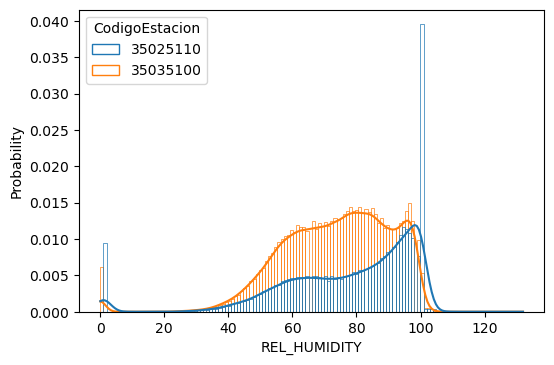

In [334]:
dfs = []
unique_stations = df_hum["CodigoEstacion"].unique()
fig = plt.figure(dpi=100)
sns.histplot(data = df_hum, x = "REL_HUMIDITY", hue = "CodigoEstacion",  palette = sns.color_palette("tab10")[0:len(unique_stations)], kde = True, fill = False, common_norm = True, stat = 'probability')
for codigoestacion in df_hum["CodigoEstacion"].unique():
    df_hum_est = df_hum[df_hum["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_hum_est = prep.filter_entries_by_column_index_values(df_hum_est, standard_var_name, params["range_hum"][0],params["range_hum"][1]) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_hum_est = prep.aggregate_data(df_hum_est, agg_type='daily', min_count = 6).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_hum_est.columns)
    df_hum_est["CodigoEstacion"] = codigoestacion
    df_hum_est = df_hum_est[columns]
    dfs.append(df_hum_est)
df_hum_daily = pd.concat(dfs, axis = 0)
df_hum_daily.describe()

In [335]:
fig = go.Figure()
for df_group in df_hum_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="HUMIDITY "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='HUMIDITY'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [336]:
stations_corr =  df_hum_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_hum_daily[df_hum_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['REL_HUMIDITY_AMAX','REL_HUMIDITY_AMIN',"REL_HUMIDITY_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['REL_HUMIDITY_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['REL_HUMIDITY_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['REL_HUMIDITY_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

35035100
                   35025110
REL_HUMIDITY_AMAX  0.734341
REL_HUMIDITY_AMIN  0.811700
REL_HUMIDITY_MEAN  0.820992

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [337]:
# Manually set the priorities for the temperature stations as per the above results!
#params["stations_hum"] = []
if len(params["stations_hum"]) == 0:
    stations_priority = [48015010, 48015050]
    params["stations_hum"] = stations_priority
    df_cities.loc[row_id,"stations_hum"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_hum"]
    print(stations_priority)
df_hum_daily = prep.combine_IDEAM_stations(df_hum_daily, stations_priority).sort_index()
df_hum_daily = df_hum_daily.resample('D').mean()
#df_hum_daily = df_hum_daily[df_hum_daily.index.date >= pd.to_datetime("2013/04/15")]

[35035100, 35025110]


In [338]:
fig = go.Figure()
plot_hum = go.Scatter(x=df_hum_daily.index,
            y=df_hum_daily[standard_var_name+"_MEAN"], name ="HUM", mode = "lines")
fig.add_trace(plot_hum)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='%'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Workflow datos del NIÑO

In [339]:
#Variable SSTOI

df_sstoi = pd.read_table(path_base+'src_general/sstoi.txt',delim_whitespace=True) 
df_sstoi.columns = ['YEAR', 'MONTH', 'SST1+2', 'ANOM1+2', 'SST3', 'ANOM3', 'SST4', 'ANOM4',
       'SST3.4', 'ANOM3.4']
df_sstoi = df_sstoi[['YEAR', 'MONTH', 'SST1+2', 'SST3', 'SST4',
       'SST3.4']]
df_sstoi.index = pd.to_datetime(df_sstoi["YEAR"].map(str)+"/"+df_sstoi["MONTH"].map(str)+"/01")
del(df_sstoi["YEAR"])
del(df_sstoi["MONTH"])
df_sstoi_daily = df_sstoi.resample('M').ffill().resample('D').bfill()
df_sstoi_daily.tail(1)

SST1+2   SST3   SST4  SST3.4
2022-02-28   24.66  25.32  27.87   26.02

In [340]:
#Variable ONI
def read_oni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-8]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split("  ")
        line = [el.replace(" ","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_oni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","ONI"]
    df_oni.columns = columns
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: x.split("-99.9")[0])
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: float(x))
    return df_oni

df_oni = read_oni_file(path_base+'src_general/oni.txt')
df_oni.index = pd.to_datetime(df_oni["YEAR"].map(str)+"/"+df_oni["MONTH"].map(str)+"/01")
del(df_oni["YEAR"])
del(df_oni["MONTH"])
df_oni_daily = df_oni.resample('M').ffill().resample('D').bfill()
df_oni_daily.tail(1)

ONI
2022-01-31 -0.97

In [341]:
def read_meiv2_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-4]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_meiv2 = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","MEI"]
    df_meiv2.columns = columns
    df_meiv2 = df_meiv2.replace("-999.00",np.nan).dropna()
    df_meiv2["MEI"] = df_meiv2["MEI"].apply(lambda x: float(x))
    return df_meiv2

df_meiv2 = read_meiv2_file(path_base+'src_general/meiv2.txt')
df_meiv2.index = pd.to_datetime(df_meiv2["YEAR"].map(str)+"/"+df_meiv2["MONTH"].map(str)+"/01")
del(df_meiv2["YEAR"])
del(df_meiv2["MONTH"])
df_meiv2_daily = df_meiv2.resample('M').ffill().resample('D').bfill()
df_meiv2_daily.tail(1)

MEI
2022-02-28 -0.97

In [342]:
def read_car_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-6]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_car = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","CAR"]
    df_car.columns = columns
    df_car = df_car.replace("-99.99",np.nan).dropna()
    df_car["CAR"] = df_car["CAR"].apply(lambda x: float(x))
    return df_car

df_car = read_car_file(path_base+'src_general/car.txt')
df_car.index = pd.to_datetime(df_car["YEAR"].map(str)+"/"+df_car["MONTH"].map(str)+"/01")
del(df_car["YEAR"])
del(df_car["MONTH"])
df_car_daily = df_car.resample('M').ffill().resample('D').bfill()
df_car_daily.tail(1)

CAR
2020-02-29  0.43

In [343]:
def read_nta_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-6]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_nta = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","NTA"]
    df_nta.columns = columns
    df_nta = df_nta.replace("-99.99",np.nan).dropna()
    df_nta["NTA"] = df_nta["NTA"].apply(lambda x: float(x))
    return df_nta

df_nta = read_nta_file(path_base+'src_general/nta.txt')
df_nta.index = pd.to_datetime(df_nta["YEAR"].map(str)+"/"+df_nta["MONTH"].map(str)+"/01")
del(df_nta["YEAR"])
del(df_nta["MONTH"])
df_nta_daily = df_nta.resample('M').ffill().resample('D').bfill()
df_nta_daily.head(1)

NTA
1950-02-28 -0.49

In [344]:
def read_tni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-10]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        #line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_tni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","TNI"]
    df_tni.columns = columns
    df_tni = df_tni.replace("-99.990",np.nan).dropna()
    df_tni["TNI"] = df_tni["TNI"].apply(lambda x: float(x))
    #df_tni["TNI"] = df_tni["TNI"].apply(lambda x: x.split("-99.")[0])
    return df_tni

df_tni = read_tni_file(path_base+'src_general/tni.txt')
df_tni.index = pd.to_datetime(df_tni["YEAR"].map(str)+"/"+df_tni["MONTH"].map(str)+"/01")
del(df_tni["YEAR"])
del(df_tni["MONTH"])
df_tni_daily = df_tni.resample('M').ffill().resample('D').bfill()
df_tni_daily.tail(1)

TNI
2021-10-31 -0.287

# SIVIGILA calendar workflow

En esta sección se combinan todos los dataframes diarios y luego se hace remuestreo por semana.

In [345]:
df_daily = prep.get_sivigila_calendar()
#Leave some months for rolling predictions
df_daily = df_daily[(df_daily.index>=pd.to_datetime("2006-09-03"))&(df_daily.index<pd.to_datetime("2021-12-31"))]
"""
df_daily = pd.merge(df_daily, df_prec_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_prec_daily[(df_prec_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily[(df_temp_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily[(df_hum_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",   left_index=True, right_index=True)
"""
#Eliminate all temperature, humidity, and precipitation data form before the established starting date -avoid gaps-
df_daily = pd.merge(df_daily, df_prec_daily[(df_prec_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily[(df_temp_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily[(df_hum_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_meiv2_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_oni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_sstoi_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_tni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_car_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_nta_daily,  how = "left",   left_index=True, right_index=True)
df_daily.tail(1)

ANO SEMANA  PRECIPITATION  TEMPERATURE_MEAN  TEMPERATURE_AMAX  \
FECHA                                                                        
2021-12-30  2021     52            NaN         25.115385              32.1   

            TEMPERATURE_AMIN  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  \
FECHA                                                                
2021-12-30              21.8               71.0               78.0   

            REL_HUMIDITY_AMIN   MEI   ONI  SST1+2   SST3   SST4  SST3.4  TNI  \
FECHA                                                                          
2021-12-30               54.0 -1.21 -0.99   21.31  24.06  27.68    25.6  NaN   

            CAR  NTA  
FECHA                 
2021-12-30  NaN  NaN

# Revisión inicial de datos faltantes

<AxesSubplot:>

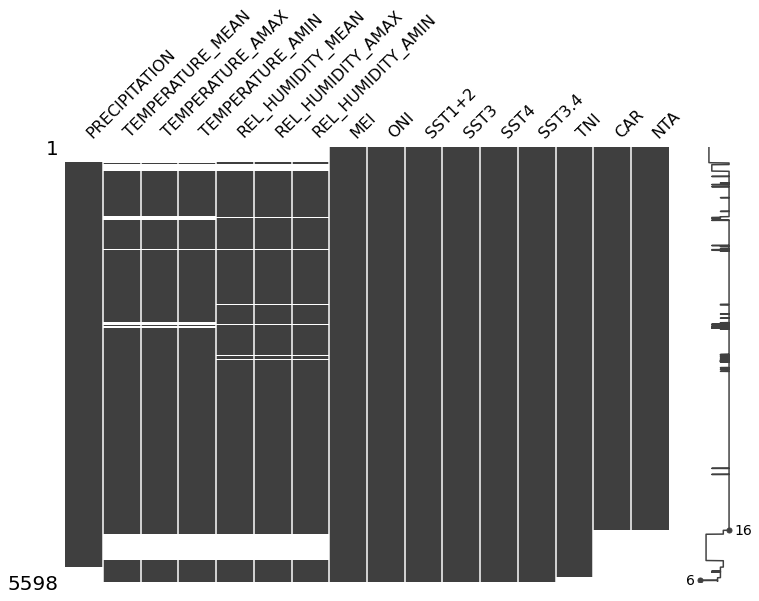

In [346]:
%matplotlib inline
msno.matrix(df_daily.iloc[:,2:], figsize =(12,8))


-----------------

In [347]:
#df_daily_interp["TEMPERATURE_RANGE"] = df_daily_interp["TEMPERATURE_AMAX"]  - df_daily_interp["TEMPERATURE_AMIN"] 
threshold_dry = 0.1 # Characteristics of consecutive dry days variations in China (2016)
df_daily["DRY_DAYS"] = df_daily["PRECIPITATION"].apply(lambda x: 1 if x < threshold_dry else 0)
df_daily = df_daily.reset_index()
df_daily.head(2)

FECHA   ANO SEMANA  PRECIPITATION  TEMPERATURE_MEAN  TEMPERATURE_AMAX  \
0 2006-09-03  2006     36            NaN               NaN               NaN   
1 2006-09-04  2006     36            NaN               NaN               NaN   

   TEMPERATURE_AMIN  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  REL_HUMIDITY_AMIN  \
0               NaN                NaN                NaN                NaN   
1               NaN                NaN                NaN                NaN   

    MEI   ONI  SST1+2   SST3   SST4  SST3.4    TNI   CAR  NTA  DRY_DAYS  
0  0.63  0.54   21.73  25.81  29.33   27.29 -0.991  0.26  0.4         0  
1  0.63  0.54   21.73  25.81  29.33   27.29 -0.991  0.26  0.4         0

In [348]:
df_weekly_sums = df_daily[["ANO","SEMANA","PRECIPITATION","DRY_DAYS"]].groupby(["ANO","SEMANA"]).sum().reset_index()
df_weekly_maxes = df_daily[["ANO","SEMANA","TEMPERATURE_AMAX","REL_HUMIDITY_AMAX"]].groupby(["ANO","SEMANA"]).max().reset_index()
df_weekly_mins = df_daily[["ANO","SEMANA","TEMPERATURE_AMIN","REL_HUMIDITY_AMIN"]].groupby(["ANO","SEMANA"]).min().reset_index()
df_weekly_means = df_daily[['ANO', 'SEMANA', 'TEMPERATURE_MEAN','REL_HUMIDITY_MEAN', 'MEI','ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'CAR','NTA']].groupby(["ANO","SEMANA"]).mean().reset_index()
df_weekly_fecha = df_daily[['ANO','SEMANA','FECHA']].groupby(["ANO","SEMANA"]).min().reset_index()
df_weekly_fecha.FECHA = pd.to_datetime(df_weekly_fecha.FECHA)

In [349]:
df_weekly = pd.merge(df_weekly_sums,df_weekly_maxes, how = "left", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_mins, how = "left", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_means, how = "left", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_fecha, how = "left", on = ["ANO","SEMANA"] )
df_weekly.head(2)

ANO SEMANA  PRECIPITATION  DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  \
0  2006     36            0.0         0               NaN                NaN   
1  2006     37            0.0         0               NaN                NaN   

   TEMPERATURE_AMIN  REL_HUMIDITY_AMIN  TEMPERATURE_MEAN  REL_HUMIDITY_MEAN  \
0               NaN                NaN               NaN                NaN   
1               NaN                NaN               NaN                NaN   

    MEI   ONI  SST1+2   SST3   SST4  SST3.4    TNI   CAR  NTA      FECHA  
0  0.63  0.54   21.73  25.81  29.33   27.29 -0.991  0.26  0.4 2006-09-03  
1  0.63  0.54   21.73  25.81  29.33   27.29 -0.991  0.26  0.4 2006-09-10

# Dengue cases workflow

In [350]:
df_dengue = pd.read_csv(path_base+"prepared_dengue/dengue_weekly_2007_2021.csv", dtype={'COD_MUNICIPIO':str})
df_dengue = df_dengue[df_dengue["COD_MUNICIPIO"]==cod_municipio]
df_dengue.FECHA = pd.to_datetime(df_dengue.FECHA)

In [351]:

#df_dengue["FECHA"] = pd.to_datetime(df_dengue["FECHA"])
df_weekly["SEMANA"] = df_weekly["SEMANA"].astype('int')
df_weekly["ANO"] = df_weekly["ANO"].astype('int')
df_weekly = pd.merge(df_weekly,df_dengue, how = "left", on = ["FECHA","ANO","SEMANA"] )
df_weekly.index = df_weekly.FECHA

# Elevation and population workflow

In [352]:
df_population = pd.read_csv(path_base+"src_general/data_per_year.csv", dtype={"COD_MUNICIPIO":str})
df_population["COD_MUNICIPIO"] = df_population["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_population = df_population[df_population["COD_MUNICIPIO"]==cod_municipio]
df_population.head(2)

ANO COD_MUNICIPIO  COD_DPTO  DENGUE  DENGUE GRAVE  \
650   2006         50001        50       0             0   
1741  2007         50001        50    1481           208   

      MORTALIDAD POR DENGUE  POBLACION  
650                       0   390384.0  
1741                      1   400537.0

In [353]:
df_municipios = pd.read_csv(path_base+"src_general/departments.csv")
df_municipios["COD_MUNICIPIO"] = df_municipios["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_municipios = df_municipios[df_municipios["COD_MUNICIPIO"]==cod_municipio]
df_weekly = pd.merge(df_weekly, df_population[["ANO","POBLACION"]], how = "left", on = "ANO")


In [354]:
df_weekly = df_weekly.set_index(["FECHA","COD_DPTO","COD_MUNICIPIO","POBLACION"])
df_weekly = df_weekly.reset_index()
df_weekly = df_weekly.set_index("FECHA")
df_weekly["COD_DPTO"] = str(df_weekly["COD_DPTO"].unique()[-1]).zfill(2)
df_weekly["COD_MUNICIPIO"] = df_weekly["COD_MUNICIPIO"].unique()[-1]
df_weekly


COD_DPTO COD_MUNICIPIO  POBLACION   ANO  SEMANA  PRECIPITATION  \
FECHA                                                                       
2006-09-03     50.0         50001   390384.0  2006      36            0.0   
2006-09-10     50.0         50001   390384.0  2006      37            0.0   
2006-09-17     50.0         50001   390384.0  2006      38            0.0   
2006-09-24     50.0         50001   390384.0  2006      39            0.0   
2006-10-01     50.0         50001   390384.0  2006      40            0.0   
...             ...           ...        ...   ...     ...            ...   
2021-11-28     50.0         50001        NaN  2021      48            0.0   
2021-12-05     50.0         50001        NaN  2021      49            0.0   
2021-12-12     50.0         50001        NaN  2021      50            0.0   
2021-12-19     50.0         50001        NaN  2021      51            0.0   
2021-12-26     50.0         50001        NaN  2021      52            0.0   

            DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  TEMPERATURE_AMIN  \
FECHA                                                                         
2006-09-03         0               NaN                NaN               NaN   
2006-09-10         0               NaN                NaN               NaN   
2006-09-17         0               NaN                NaN               NaN   
2006-09-24         0               NaN                NaN               NaN   
2006-10-01         0               NaN                NaN               NaN   
...              ...               ...                ...               ...   
2021-11-28         0              32.0               96.0              22.1   
2021-12-05         0              31.8               96.0              21.5   
2021-12-12         0              31.7               89.0              22.9   
2021-12-19         0              31.9               94.0              23.4   
2021-12-26         0              32.4               89.0              21.8   

            ...     SST1+2       SST3       SST4     SST3.4    TNI   CAR  \
FECHA       ...                                                            
2006-09-03  ...  21.730000  25.810000  29.330000  27.290000 -0.991  0.26   
2006-09-10  ...  21.730000  25.810000  29.330000  27.290000 -0.991  0.26   
2006-09-17  ...  21.730000  25.810000  29.330000  27.290000 -0.991  0.26   
2006-09-24  ...  21.730000  25.810000  29.330000  27.290000 -0.991  0.26   
2006-10-01  ...  22.480000  25.880000  29.320000  27.420000 -1.131  0.25   
...         ...        ...        ...        ...        ...    ...   ...   
2021-11-28  ...  21.095714  24.218571  27.812857  25.758571    NaN   NaN   
2021-12-05  ...  21.310000  24.060000  27.680000  25.600000    NaN   NaN   
2021-12-12  ...  21.310000  24.060000  27.680000  25.600000    NaN   NaN   
2021-12-19  ...  21.310000  24.060000  27.680000  25.600000    NaN   NaN   
2021-12-26  ...  21.310000  24.060000  27.680000  25.600000    NaN   NaN   

             NTA  DENGUE  DENGUE GRAVE  MORTALIDAD POR DENGUE  
FECHA                                                          
2006-09-03  0.40     NaN           NaN                    NaN  
2006-09-10  0.40     NaN           NaN                    NaN  
2006-09-17  0.40     NaN           NaN                    NaN  
2006-09-24  0.40     NaN           NaN                    NaN  
2006-10-01  0.49     NaN           NaN                    NaN  
...          ...     ...           ...                    ...  
2021-11-28   NaN     7.0           0.0                    0.0  
2021-12-05   NaN     9.0           0.0                    0.0  
2021-12-12   NaN    16.0           0.0                    0.0  
2021-12-19   NaN    20.0           1.0                    0.0  
2021-12-26   NaN     8.0           0.0                    0.0  

[800 rows x 25 columns]

In [355]:
df_weekly.head()

COD_DPTO COD_MUNICIPIO  POBLACION   ANO  SEMANA  PRECIPITATION  \
FECHA                                                                       
2006-09-03     50.0         50001   390384.0  2006      36            0.0   
2006-09-10     50.0         50001   390384.0  2006      37            0.0   
2006-09-17     50.0         50001   390384.0  2006      38            0.0   
2006-09-24     50.0         50001   390384.0  2006      39            0.0   
2006-10-01     50.0         50001   390384.0  2006      40            0.0   

            DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  TEMPERATURE_AMIN  \
FECHA                                                                         
2006-09-03         0               NaN                NaN               NaN   
2006-09-10         0               NaN                NaN               NaN   
2006-09-17         0               NaN                NaN               NaN   
2006-09-24         0               NaN                NaN               NaN   
2006-10-01         0               NaN                NaN               NaN   

            ...  SST1+2   SST3   SST4  SST3.4    TNI   CAR   NTA  DENGUE  \
FECHA       ...                                                            
2006-09-03  ...   21.73  25.81  29.33   27.29 -0.991  0.26  0.40     NaN   
2006-09-10  ...   21.73  25.81  29.33   27.29 -0.991  0.26  0.40     NaN   
2006-09-17  ...   21.73  25.81  29.33   27.29 -0.991  0.26  0.40     NaN   
2006-09-24  ...   21.73  25.81  29.33   27.29 -0.991  0.26  0.40     NaN   
2006-10-01  ...   22.48  25.88  29.32   27.42 -1.131  0.25  0.49     NaN   

            DENGUE GRAVE  MORTALIDAD POR DENGUE  
FECHA                                            
2006-09-03           NaN                    NaN  
2006-09-10           NaN                    NaN  
2006-09-17           NaN                    NaN  
2006-09-24           NaN                    NaN  
2006-10-01           NaN                    NaN  

[5 rows x 25 columns]

In [356]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly.index,
            y=df_weekly["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="WEEKLY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Missing data imputation

<AxesSubplot:>

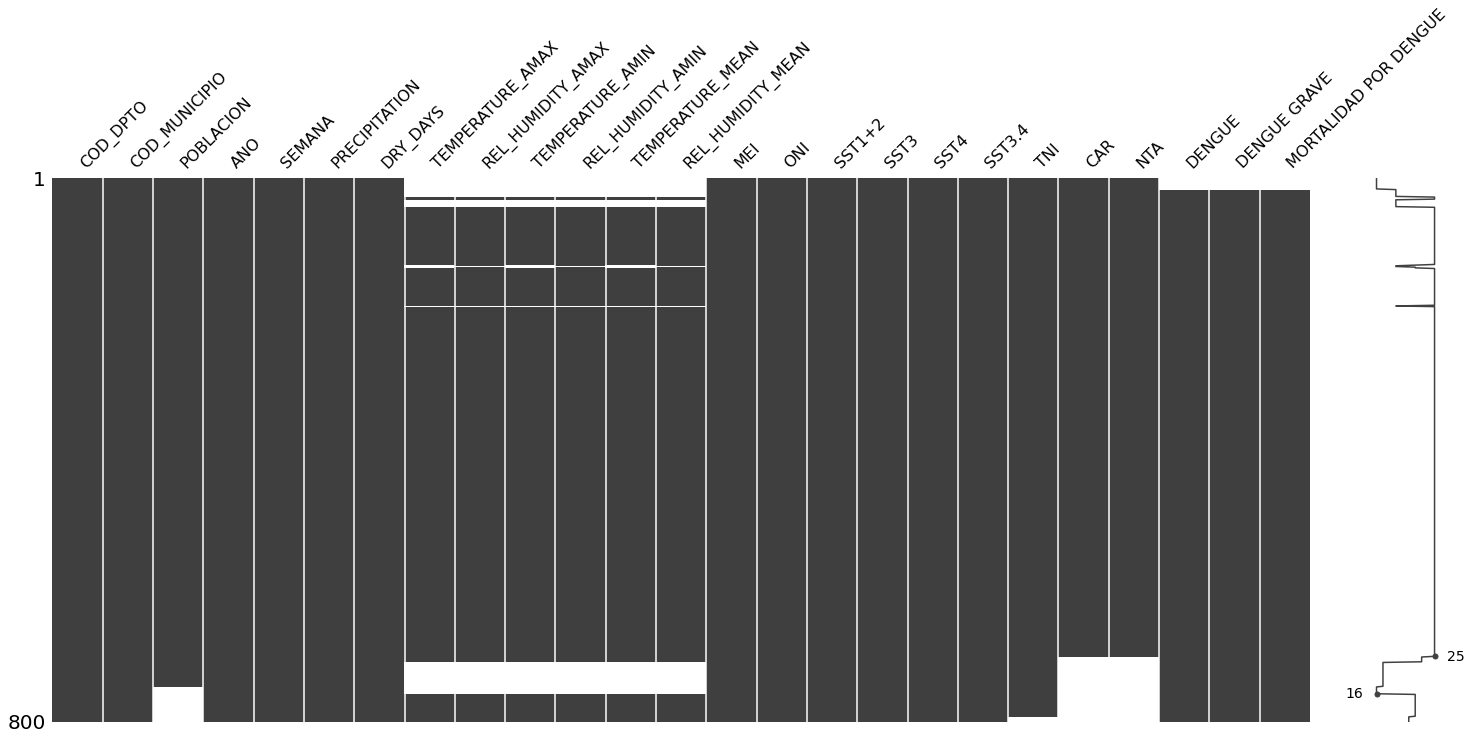

In [357]:
msno.matrix(df_weekly)

In [358]:
vars_to_imput = [
            "PRECIPITATION",
            "TEMPERATURE_MEAN",
            "TEMPERATURE_AMAX",
            "TEMPERATURE_AMIN",
            "REL_HUMIDITY_MEAN",
            "REL_HUMIDITY_AMAX",
            "REL_HUMIDITY_AMIN",
        ]

In [359]:
df_weekly_interp_model = df_weekly.copy()
df_weekly_interp_model.iloc[18:,:] = prep.imput_data_with_sklearn_imputer(df_weekly.iloc[18:,:])
df_weekly_interp = df_weekly.interpolate("nearest")
df_weekly_interp_means = prep.imput_with_mean_of_week(df_weekly)
df_weekly_imput_windowed = prep.imput_with_wind_mean_of_week(df_weekly)
df_weekly_final = df_weekly.copy()
df_weekly_final[vars_to_imput] = (df_weekly_interp_model[vars_to_imput]*0.1+df_weekly_imput_windowed[vars_to_imput]*0.9+df_weekly_interp[vars_to_imput]*0.)

In [360]:
df_weekly_final["TEMPERATURE_RANGE"] = df_weekly_final["TEMPERATURE_AMAX"] - df_weekly_final["TEMPERATURE_AMIN"]
df_weekly_final = df_weekly_final[['COD_DPTO', 'COD_MUNICIPIO', 'POBLACION', 'ANO', 'SEMANA',
    'PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
    'TEMPERATURE_AMIN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN',
    'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4',
    'TNI', 'CAR', 'NTA', 'DENGUE', 'DENGUE GRAVE', 'MORTALIDAD POR DENGUE']]

In [361]:
var = "TEMPERATURE_MEAN"
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly_final.index,
            y=df_weekly_final[var], name ="FILLED", mode = "lines")
plot_temp_nofill = go.Scatter(x=df_weekly.index,
            y=df_weekly[var], name ="ORIGINAL", mode = "lines")
fig.add_trace(plot_temp)
fig.add_trace(plot_temp_nofill)
layout = go.Layout(title="WEEKLY "+var+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [362]:
df_weekly_final = df_weekly_final[df_weekly_final.index>=params['starting_date']]

In [363]:
df_weekly_final.to_csv(path_base+f"prepared_per_city/{prep.municipality_name_to_filename(params['municipality'])}_consolidado_{params['starting_date'][0:4]}_2021.csv",index = True)

<AxesSubplot:>

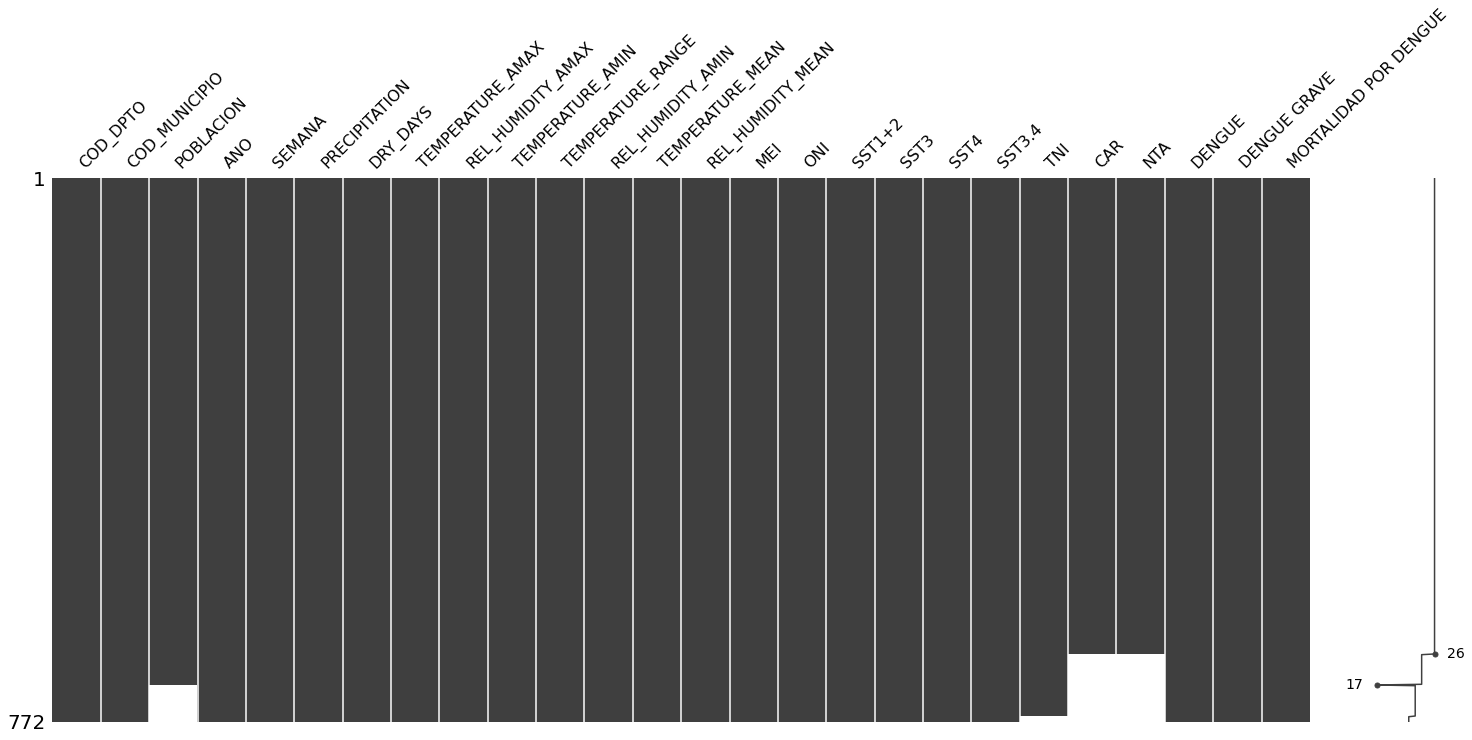

In [364]:
msno.matrix(df_weekly_final)

In [220]:
#df_daily_interp = prep.imput_data_with_sklearn_imputer(df_daily)
#df_daily_interp = prep.imput_data_with_closest_and_mean(df_daily)
#df_daily_interp = df_daily.interpolate(method="time")
"""fig = go.Figure()
plot_temp = go.Scatter(x=df_daily.index,
            y=df_daily["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()
""";